# Fake or Real News

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import re
from google.colab import files

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [53]:
%%bash

# check if already installed
pip list -v | grep kaggle 
if [ $? -ne 0 ]; then
  pip install kaggle
fi

kaggle                        1.5.12                /usr/local/lib/python3.7/dist-packages pip


In [54]:
dir_path = "/content/kaggle.json"

if not os.path.isfile(dir_path):

  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

else:
  print("Kaggle.json already uploaded!!")

Kaggle.json already uploaded!!


## Download Dataset

In [55]:
%%bash

if [ ! -d /content/datasets ]; then

  mkdir -p /content/datasets

  mkdir -p /root/.kaggle/
  rm /root/.kaggle/kaggle.json
  cp /content/kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

  kaggle datasets download -d jainpooja/fake-news-detection

  mv /content/fake-news-detection.zip /content/datasets/
  unzip /content/datasets/fake-news-detection.zip -d /content/datasets/
fi

Dataset contains 2 csv files
- Fake.csv
- Real.csv

Each of them have 4 columns **title, text, subject and date**.
Dataset is mostly balanced with fake news - 23481 & real news - 21417 rows

In [56]:
# check if encoding required!
fake_df = pd.read_csv("/content/datasets/Fake.csv")
real_df = pd.read_csv("/content/datasets/True.csv")

In [57]:
fake_df['isTrue'] = 0
real_df['isTrue'] = 1

In [58]:
complete_df = pd.concat([fake_df, real_df], axis = 0)

## Explore Dataset

In [59]:
complete_df.head()

,title,text,subject,date,isTrue
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [60]:
complete_df.columns

Index(['title', 'text', 'subject', 'date', 'isTrue'], dtype='object')

In [61]:
complete_df.isna().sum()

title      0
text       0
subject    0
date       0
isTrue     0
dtype: int64

In [62]:
print(f"Before dropping duplicates in dataset: {len(complete_df)}")
complete_df.drop_duplicates(subset=['title', 'text'], inplace=True)
print(f"After dropping duplicates in dataset: {len(complete_df)}")

Before dropping duplicates in dataset: 44898
After dropping duplicates in dataset: 39105


In [63]:
complete_df['date'] = pd.to_datetime(complete_df['date'], errors='coerce')
complete_df['title'] = complete_df['title'].astype('str')
complete_df['text'] = complete_df['text'].astype('str')
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39105 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    39105 non-null  object        
 1   text     39105 non-null  object        
 2   subject  39105 non-null  object        
 3   date     39099 non-null  datetime64[ns]
 4   isTrue   39105 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.8+ MB


In [64]:
# For viz
complete_df_copy = complete_df.copy()

## Helper Constants and Functions

In [65]:
SEED = 727
TRAIN_SIZE = 0.8

In [66]:
# Functions that maybe useful in future works!

# spell correction (use if required)
# from textblob import TextBlob
# complete_df['titleplustext'][0:5].apply(lambda x: str(TextBlob(x).correct()))

def removeUrls(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'',  text)

def removeHTMLTags(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

def removeEmoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def lemmizeWords(textRow):
  wnl = WordNetLemmatizer()
  return list(
          map(lambda w: wnl.lemmatize(w),
            textRow))

# For a quick test!
# removeUrls("https://google.com and www.google.com is a cool websites")
# removeHTMLTags("</P><b>hold<b> your ground soldier!</P>")
# removeEmoji("I ❤️ you!")

In [67]:
# Text processing functions used for this dataset

IGNORE_WORDS_STARTING_WITH = ('@', '#', 'https')

def tokenize(textRow):
  return word_tokenize(textRow)

# removes puntuations as well
def removeDigits(textRow):
  return list(
          filter( lambda w: w.isalpha(), 
                textRow))

def removeStopWords(textRow):
  return list(
          filter(lambda w: w not in stop_words, 
               textRow))

# remove https links / twiter handles / hashtags
def cleantext(textRow):
  return list(
          filter(lambda w: not (w.startswith(IGNORE_WORDS_STARTING_WITH)),
               textRow))

def stemWords(textRow):
  porter = PorterStemmer()
  return list(
          map(lambda w: porter.stem(w),
            textRow))
  

## Visualization of dataset

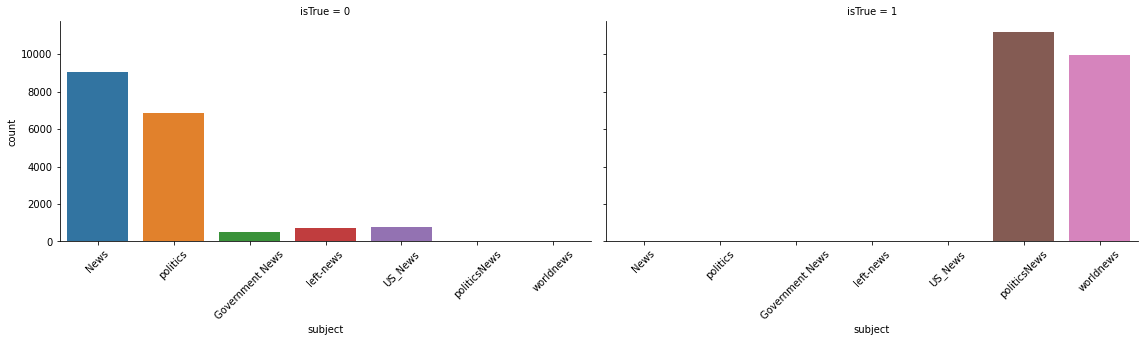

In [68]:
g = sns.catplot(x="subject", col="isTrue",
                data=complete_df, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

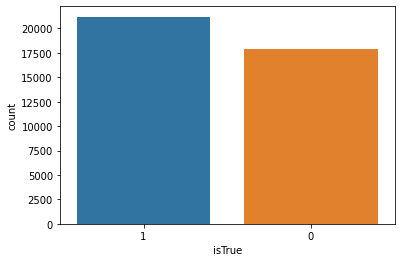

In [69]:
sns.countplot(x='isTrue', data=complete_df_copy, order=complete_df_copy['isTrue'].value_counts().index)

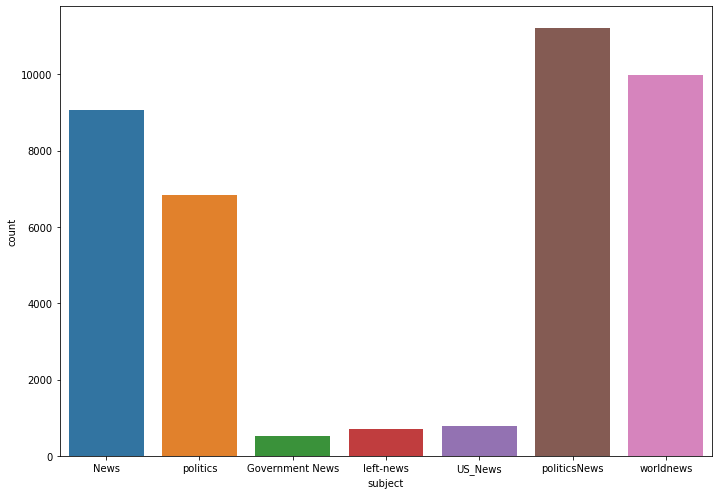

In [70]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x='subject', data=complete_df_copy, ax=ax)

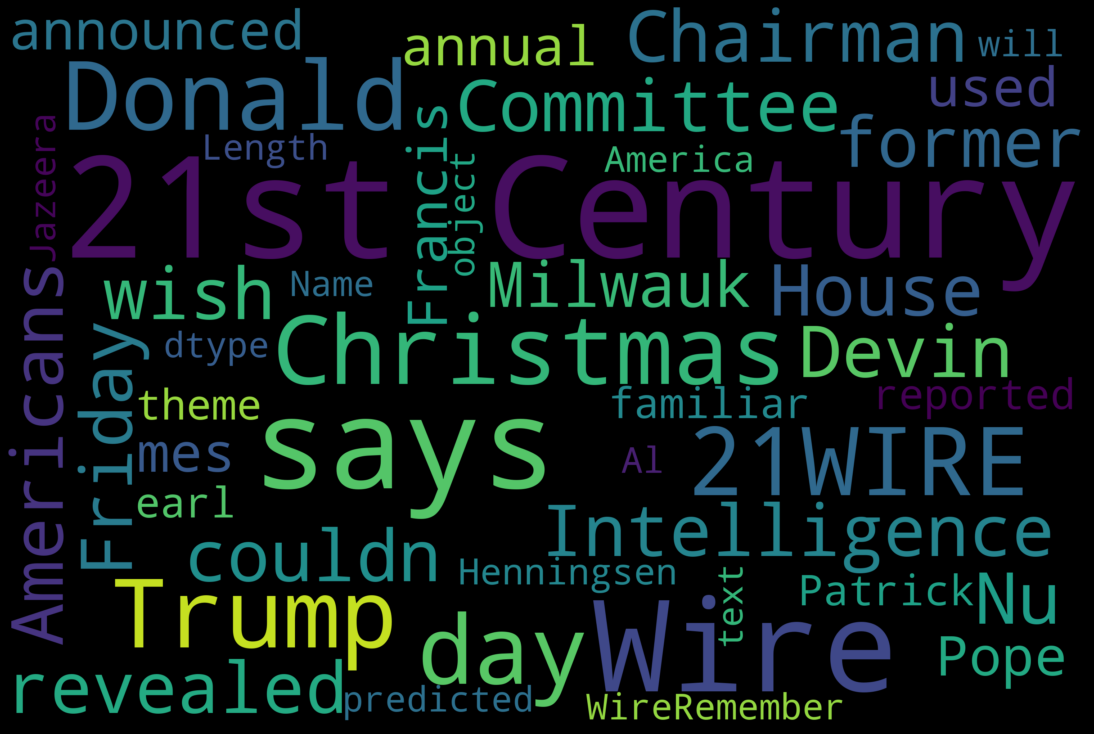

In [71]:
text = fake_df["text"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

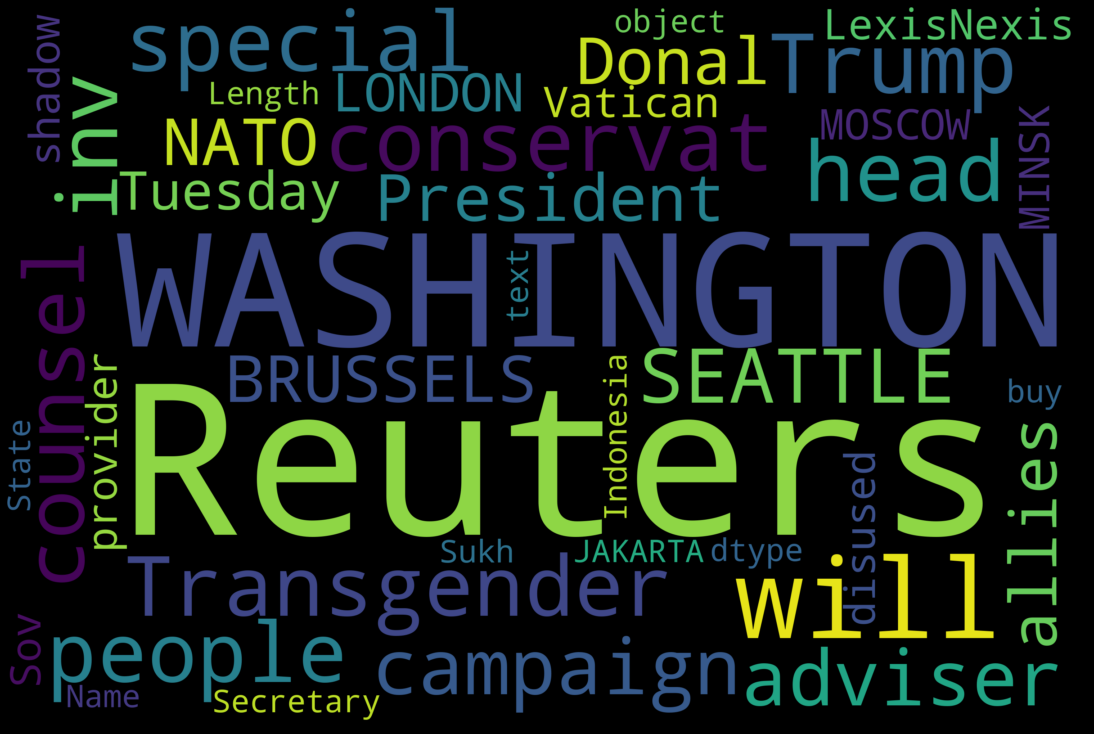

In [72]:
text = real_df["text"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing Dataset

In [73]:
# using only text based features for prediction
complete_df.drop(['date'], axis = 1, inplace=True)

In [74]:
complete_df['titleplustext'] = complete_df['title'] + ' ' + complete_df['text']
complete_df.drop(['title', 'text', 'subject'], axis = 1, inplace=True)

In [75]:
complete_df.head(10)

,isTrue,titleplustext
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...
5,0,Racist Alabama Cops Brutalize Black Boy While...
6,0,"Fresh Off The Golf Course, Trump Lashes Out A..."
7,0,Trump Said Some INSANELY Racist Stuff Inside ...
8,0,Former CIA Director Slams Trump Over UN Bully...
9,0,WATCH: Brand-New Pro-Trump Ad Features So Muc...


In [76]:
# What words are found most often?
freq = pd.Series(' '.join(complete_df['titleplustext']).split()).value_counts()[0:20]
freq

the      770682
to       463993
of       375201
a        337478
and      335513
in       283081
that     188913
on       163996
for      145856
s        141522
is       136253
Trump    101670
with      99240
was       95823
he        94327
The       86938
said      86476
as        83614
his       80950
by        79972
dtype: int64

**Stemming vs Lemmatization**

Both stemming and lemmatization are word normalization techniques. 
They are very often used when implementing search engines to handle variations of the same word properly.

- Stemming - Stemming is a process of reducing words to its root form even if the root has no dictionary meaning. 
For eg: beautiful and beautifully will be stemmed to beauti which has no meaning in English dictionary.

- Lemmatisation - Lemmatisation is a process of reducing words into their lemma or dictionary. 
It takes into account the meaning of the word in the sentence. 
For eg: beautiful and beautifully are lemmatised to beautiful and beautifully respectively without changing the meaning of the words. 
But, good, better and best are lemmatised to good since all the words have similar meaning.

lemmatization is almost always a better choice from a qualitative point of view.

In [77]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [78]:
def textPreprocessing(textRow):
  textRow = str.lower(textRow)
  textRow = tokenize(textRow)
  textRow = removeDigits(textRow)
  textRow = removeStopWords(textRow)
  textRow = cleantext(textRow)
  textRow = stemWords(textRow)
  
  return ' '.join(textRow)


In [79]:
example = "This is #done @to check if preprocessing funct10n is running properly on (https://colab.research.google.com/)"
textPreprocessing(example)

'done check preprocess run properli'

In [80]:
complete_df['titleplustext'] = complete_df['titleplustext'].apply(lambda x: textPreprocessing(x))

In [81]:
complete_df.head()

,isTrue,titleplustext
0,0,donald trump send embarrass new year eve messa...
1,0,drunk brag trump staffer start russian collus ...
2,0,sheriff david clark becom internet joke threat...
3,0,trump obsess even obama name code websit imag ...
4,0,pope franci call donald trump christma speech ...


In [82]:
# In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage 
# of samples of each target class as the complete set.

X = complete_df['titleplustext']
y = complete_df['isTrue']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE, 
                                                    random_state=SEED, 
                                                    shuffle=True, 
                                                    stratify=complete_df['isTrue'])

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31284,), (7821,), (31284,), (7821,))

**Extracting features from text based data**

- **Bag of words**
get counts of each token (word) in text data
convert it into sparse array
disregarding grammar and even word order but keeping multiplicity.

- **Term frequency inverse document frequency**
TF-IDF is short for term frequency–inverse document frequency. 
It’s designed to reflect how important a word is to a document in a collection or corpus.

TF-IDF value increases proportionally to the number of times a word appears in the document and 
is offset by the number of documents in the corpus that contain the word, 
which helps to adjust for the fact that some words appear more frequently in general.


In [84]:
tfidvect = TfidfVectorizer()

tfid_x_train = tfidvect.fit_transform(X_train)
tfid_x_test = tfidvect.transform(X_test)

In [85]:
# Use hstack to put all the text + non text features in one dataframe. 
# eg. X_tr=hstack((vectorised_text_features...., standardised_numerical_features..., standardised_categorical_features...)) 
# And, your Train Data is ready. 

## Model

### 1) Logistic Regression

In [86]:
log_reg = LogisticRegression().fit(tfid_x_train, y_train)

In [87]:
y_pred = log_reg.predict(tfid_x_test)
log_reg.score(tfid_x_test, y_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9860631632783532
Precision: 0.9806797020484171
Recall: 0.993866477942911


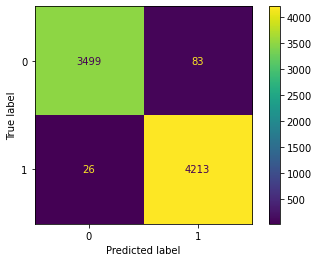

In [88]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### 2) Support Vector Machines

In [89]:
# takes a bit of while!
svc = SVC().fit(tfid_x_train, y_train)

In [90]:
y_pred = svc.predict(tfid_x_test)
svc.score(tfid_x_test, y_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9914333205472446
Precision: 0.9885245901639345
Recall: 0.9957537154989384


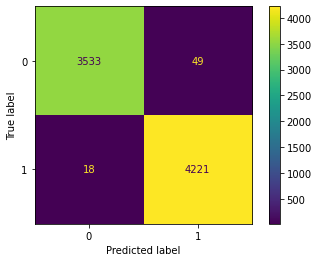

In [91]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Predict your own news sample!

In [92]:
# https://www.reuters.com/article/uk-usa-trump-afghanistan-nato-idAFKCN1B20OA --> Testing on a real news sample

sample_news = """Having run for the White House last year on a pledge to withdraw swiftly from Afghanistan, Trump reversed course on Monday and promised a stepped-up military campaign against Taliban insurgents, saying: “Our troops will fight to win”.
U.S. officials said he had signed off on plans to send about 4,000 more U.S. troops to add to the roughly 8,400 now deployed in Afghanistan.
But his speech did not define benchmarks for successfully ending the war that began with the U.S.-led invasion of Afghanistan in 2001, and which he acknowledged had required an “extraordinary sacrifice of blood and treasure”.
“We will ask our NATO allies and global partners to support our new strategy, with additional troops and funding increases in line with our own. We are confident they will,” Trump said.
That comment signalled he would further increase pressure on U.S. partners who have already been jolted by his repeated demands to step up their contributions to NATO and his description of the alliance as “obsolete” - even though, since taking office, he has said this is no longer the case.
NATO Secretary General Jens Stoltenberg said in a statement: “NATO remains fully committed to Afghanistan and I am looking forward to discussing the way ahead with (Defense) Secretary (James) Mattis and our Allies and international partners.”
NATO has 12,000 troops in Afghanistan, and 15 countries have pledged more, Stoltenberg said. Britain, a leading NATO member, called the U.S. commitment “very welcome”.
“In my call with Secretary Mattis yesterday we agreed that despite the challenges, we have to stay the course in Afghanistan to help build up its fragile democracy and reduce the terrorist threat to the West,” Defence Secretary Michael Fallon said.
Germany, which has borne the brunt of Trump’s criticism over the scale of its defence spending, also welcomed the new U.S. plan.
“Our continued commitment is necessary on the path to stabilising the country,” a government spokeswoman said.
In June, European allies had already pledged more troops but had not given details on numbers, waiting for the Trump administration to outline its strategy for the region.Nearly 16 years after the U.S.-led invasion - a response to the Sept. 11 attacks which were planned by al Qaeda leader Osama bin Laden from Afghanistan - the country is still struggling with weak central government and a Taliban insurgency.
Trump said he shared the frustration of the American people who were “weary of war without victory”, but a hasty withdrawal would create a vacuum for groups like Islamic State and al Qaeda to fill."""

In [93]:
preprocessed_news =  textPreprocessing(sample_news)
input = [preprocessed_news]

In [94]:
tfid_news = tfidvect.transform(input)
y_pred = log_reg.predict(tfid_news)
y_pred

array([1])

Model correctly predicts the sample news to be true. Since train dataset had a lot of trump and US election related news, I chose an appropriate new sample!

## Future scope of work
- Model is perforing pretty well, but the input data is not as generalised as expected, so news from all sectors and media outlets can help form a better generalised model as well.

## Reference
- https://www.kaggle.com/c/instant-gratification/discussion/92817
- https://python.plainenglish.io/the-ultimate-numpy-cheat-sheet-3e4a5799ac5
- https://stackabuse.com/map-filter-and-reduce-in-python-with-examples/
- https://towardsai.net/p/nlp/extracting-features-from-text-data
- https://library-nd.libguides.com/fakenews/examples